In [1]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import os
from rasterstats import zonal_stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from shapely.errors import ShapelyDeprecationWarning
from glob import glob
from rioxarray.merge import merge_arrays
import rasterio
from shapely.geometry import Polygon, Point
import random
#suppress ShapelyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [2]:
CRS = "EPSG:32634"
GEOTIFF_OPTIM_DIR = 'data/output/geotiff_optim'
GEOTIFF_CAL_DIR = "data/output/geotiff_cal"
CENTERLINE_PATH = "data/input/shapes/kocinka_centerline.geojson"
GROUND_POINTS_PATH = "data/input/shapes/kocinka_ground_points.geojson"
GROUND_POINTS_RADIUS = 4

In [3]:
# geometries = []
# names = []
# for path in tqdm(glob(f"{GEOTIFF_OPTIM_DIR}/*.tiff")):
#     raster = rxr.open_rasterio(path)
#     footprints = rasterio.features.shapes((raster != raster.rio.nodata).values.astype(np.int16), transform=raster.rio.transform())
#     footprints = [Polygon(geom["coordinates"][0]).simplify(10) for geom, colval in footprints if colval == 1]
#     assert len(footprints) == 1, "More than one footprint found"
#     names.append(os.path.basename(path))
#     geometries.append(footprints[0])
# footprints = gpd.GeoDataFrame({"name": names, "geometry": geometries}, crs=CRS)

In [4]:
# footprint = footprints.dissolve().buffer(-RADIUS).geometry[0]
# random_points = []
# minx, miny, maxx, maxy = footprint.bounds
# seed = 0
# while len(random_points) < CIRCLES:
#     seed += 1
#     pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
#     if footprint.contains(pnt):
#         random_points.append(pnt)
# random_points = gpd.GeoDataFrame({"geometry": random_points}, crs=CRS)
# random_points = random_points.buffer(RADIUS)

In [5]:
ground_points = gpd.read_file(GROUND_POINTS_PATH)
ground_points = ground_points.buffer(GROUND_POINTS_RADIUS)
print("Calculating zonal statistics...")
y = {"cal": [], "uncal": []}
x = {"cal": [], "uncal": []}
for raster_dir, cal in zip([GEOTIFF_OPTIM_DIR,GEOTIFF_CAL_DIR],["uncal", "cal"]):
    names = [ name for name in os.listdir(raster_dir) if name.endswith(".tiff") ]
    names = sorted(names)

    for i, name in enumerate(tqdm(names)):
        #parse time to datetime
        #time = datetime.strptime(name.split("_")[1], "%Y%m%d%H%M%S")
        raster = rxr.open_rasterio(f"{raster_dir}/{name}")
        stats = zonal_stats(ground_points, raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)

        for j, stat in enumerate(stats):
            if stat["mean"] != None:
                y[cal].append(stat["mean"])
                x[cal].append(j)

Calculating zonal statistics...


100%|██████████| 453/453 [03:02<00:00,  2.49it/s]


In [6]:
#calculate standard deviation for each point
y_std = {"cal": [], "uncal": []}
for cal in ["cal", "uncal"]:
    for i in range(len(x[cal])):
        y_std[cal].append(np.std(y[cal][i::len(x[cal])]))

In [13]:
y_std

{'cal': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

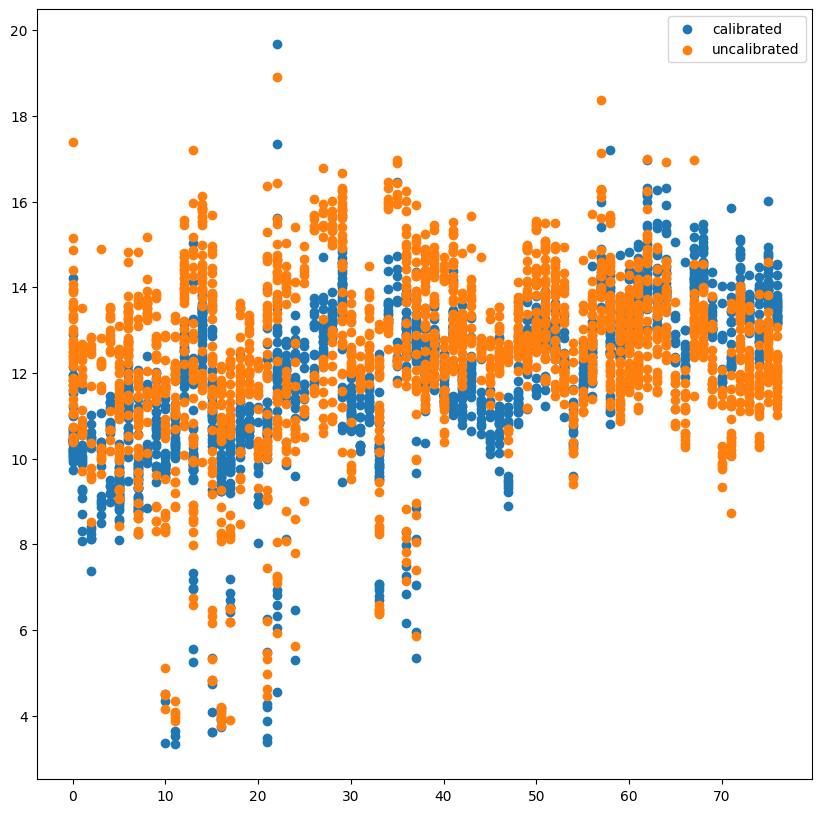

In [7]:
#plot results
plt.figure(figsize=(10,10))
plt.scatter(x["cal"], y["cal"], label="calibrated")
plt.scatter(x["uncal"], y["uncal"], label="uncalibrated")
plt.legend()
plt.show()

In [8]:
#open data/centerline.json
centerline = gpd.read_file(CENTERLINE_PATH)
#reproject centerline to 'epsg:32634'
centerline = centerline.to_crs(CRS)
#generate points along centerline every 0.1 meters
distance_delta = 5
distances = np.arange(0, centerline.length[0], distance_delta)
points = [centerline.geometry.interpolate(distance)[0] for distance in distances]
river_pts_gdf = gpd.GeoDataFrame({'geometry': points, 'chainage': distances}, crs=CRS)
#buffer points to 0.1 meters
river_pts_gdf["geometry"] = river_pts_gdf.buffer(0.2)

In [9]:
print("Calculating zonal statistics...")
x = {"cal": [], "uncal": []}
y = {"cal": [], "uncal": []}
z = {"cal": [], "uncal": []}
for raster_dir, cal in zip([GEOTIFF_OPTIM_DIR,GEOTIFF_CAL_DIR],["uncal", "cal"]):
    names = [ name for name in os.listdir(raster_dir) if name.endswith(".tiff") ]
    names = sorted(names)

    for i, name in enumerate(tqdm(names)):
        #parse time to datetime
        time = datetime.strptime(name.split("_")[1], "%Y%m%d%H%M%S")
        raster = rxr.open_rasterio(f"{raster_dir}/{name}")
        stats = zonal_stats(river_pts_gdf['geometry'], raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)

        for j, stat in enumerate(stats):
            if stat["mean"] != None:
                if stat["mean"] < raster.rio.nodata:
                    print(name, cal)
                y[cal].append(stat["mean"])
                x[cal].append(river_pts_gdf["chainage"][j])
                z[cal].append(time)

Calculating zonal statistics...


100%|██████████| 453/453 [02:25<00:00,  3.11it/s]


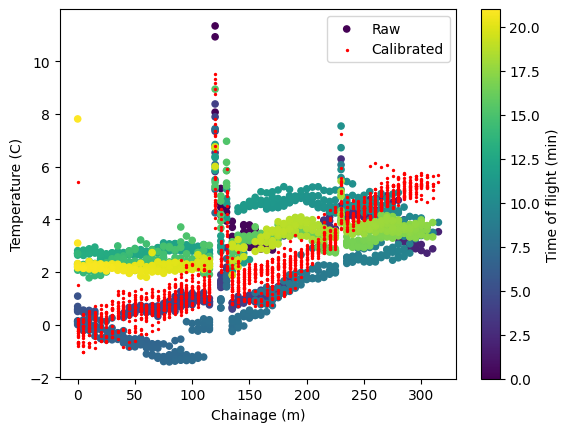

In [10]:
#plot scatter x vs y with color z
import matplotlib.pyplot as plt

first_date = min(z["uncal"]).timestamp()
timestamps = [(date.timestamp() - first_date) for date in z["uncal"]]
#convert timestamps to minutes
timestamps = [timestamp/60 for timestamp in timestamps]
cplot = plt.scatter(x["uncal"], y["uncal"], c=timestamps, cmap="viridis", s=20, label="Raw")
plt.scatter([x["cal"]], y["cal"], c="red", s=2, label="Calibrated")
plt.xlabel("Chainage (m)")
plt.ylabel("Temperature (C)")
plt.legend()
#set color label as time
cbar = plt.colorbar(cplot, label="Time of flight (min)")
#plt.ylim(4,14)
plt.show()

In [11]:
#calculate std for each x
uncal_stds = []
cal_stds = []
for i in range(0, len(x["uncal"]), 100):
    uncal_stds.append(np.std(y["uncal"][i:i+100]))
    cal_stds.append(np.std(y["cal"][i:i+100]))

In [12]:
def average_merge(merged_data, new_data, merged_mask, new_mask, index=None, roff=None, coff=None):
    merged_data_masked = np.ma.array(merged_data, mask=merged_mask)
    merged_data[:] = np.ma.masked_array((merged_data_masked,new_data)).mean(axis=0)
print("Merging calibrated rasters...")
rasters = []
for path in tqdm(glob(f"{GEOTIFF_CAL_DIR}/*.tiff")):
    rasters.append(rxr.open_rasterio(path, masked=True).copy())

mosaic = merge_arrays(rasters, method=average_merge)
mosaic.rio.to_raster("data/output/mosaic_cal.tiff")

print("Merging uncalibrated rasters...")
rasters = []
for path in tqdm(glob(f"{GEOTIFF_OPTIM_DIR}/*.tiff")):
    rasters.append(rxr.open_rasterio(path, masked=True).copy())
mosaic = merge_arrays(rasters, method=average_merge)
mosaic.rio.to_raster("data/output/mosaic_uncal.tiff")

Merging calibrated rasters...


100%|██████████| 453/453 [00:07<00:00, 60.53it/s]


Merging uncalibrated rasters...


100%|██████████| 453/453 [00:07<00:00, 62.01it/s]
